In [2]:
from google.cloud import bigquery
from google.cloud import bigquery_storage
creds = "/Users/srdeo/OneDrive - Copart, Inc/secrets/cprtpr-datastewards-sp1-614d7e297848 (1).json"
client = bigquery.Client.from_service_account_json(json_credentials_path=creds)
bqstorageclient = bigquery_storage.BigQueryReadClient(credentials=creds)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import warnings
import numpy as np
import pandas as pd

warnings.filterwarnings("ignore")

### Extracting Churn Members from

In [4]:
from datetime import datetime, timedelta
import pandas as pd

# Generate list of month starts from May 2024 to April 2025
month_starts = pd.date_range(start='2024-05-01', end='2025-04-01', freq='MS')

query_parts = []

for start_date in month_starts:
    end_date = (start_date + pd.offsets.MonthEnd(1)).date()
    month_label = start_date.strftime('%Y-%m')
    start_str = start_date.strftime('%Y-%m-%d')
    end_str = end_date.strftime('%Y-%m-%d')

    # Non-churn block
    non_churn = f"""
    SELECT
        m.owner_mbr_nbr,
        m.mbr_nbr,
        m.mbr_type,
        m.mbr_mbrshp_type_cd,
        e.event_type,
        e.event_value,
        DATE_TRUNC(e.event_value, MONTH) AS event_month,
        '{month_label}' AS month_label,
        0 AS churn
    FROM `cprtpr-dataplatform-sp1`.usviews.v_us_member_fact m
    JOIN `cprtpr-dataplatform-sp1`.usmart.v_us_member_events_fact e
        ON m.mbr_nbr = e.mbr_nbr
    WHERE m.mbr_type = 'PREMIER'
      AND e.event_type = 'Member Premier Renewal Paid Date'
      AND e.event_value BETWEEN '{start_str}' AND '{end_str}'
    """

    # Churn block
    churn = f"""
    SELECT
        m.owner_mbr_nbr,
        m.mbr_nbr,
        m.mbr_type,
        m.mbr_mbrshp_type_cd,
        e.event_type,
        e.event_value,
        DATE_TRUNC(e.event_value, MONTH) AS event_month,
        '{month_label}' AS month_label,
        1 AS churn
    FROM `cprtpr-dataplatform-sp1`.usviews.v_us_member_fact m
    JOIN `cprtpr-dataplatform-sp1`.usmart.v_us_member_events_fact e
        ON m.mbr_nbr = e.mbr_nbr
    WHERE m.mbr_type = 'LPSDPREMIER'
      AND e.event_type = 'MEMBER TYPE UPDATED FROM PREMIER TO GUEST'
      AND e.event_value BETWEEN '{start_str}' AND '{end_str}'
    """

    query_parts.append(non_churn)
    query_parts.append(churn)

# Combine all parts with UNION ALL
final_query = "\nUNION ALL\n".join(query_parts)

# Run the query
data1 = client.query(final_query).to_dataframe()


* Trying new logic (1 query)

In [7]:
from datetime import datetime, timedelta
import pandas as pd

# Generate list of month starts from May 2024 to April 2025
month_starts = pd.date_range(start='2024-05-01', end='2025-04-01', freq='MS')

query_parts = []

for start_date in month_starts:
    end_date = (start_date + pd.offsets.MonthEnd(1)).date()
    month_label = start_date.strftime('%Y-%m')
    start_str = start_date.strftime('%Y-%m-%d')
    end_str = end_date.strftime('%Y-%m-%d')

    # Combined block with CASE WHEN for churn
    query = f"""
    SELECT
        m.owner_mbr_nbr,
        m.mbr_nbr,
        m.mbr_type,
        m.mbr_mbrshp_type_cd,
        e.event_type,
        e.event_value,
        DATE_TRUNC(e.event_value, MONTH) AS event_month,
        '{month_label}' AS month_label,
        CASE
            WHEN m.mbr_type = 'LPSDPREMIER' AND e.event_type = 'MEMBER TYPE UPDATED FROM PREMIER TO GUEST' THEN 1
            WHEN m.mbr_type = 'PREMIER' AND e.event_type = 'Member Premier Renewal Paid Date' THEN 0
            ELSE NULL
        END AS churn
    FROM `cprtpr-dataplatform-sp1`.usviews.v_us_member_fact m
    JOIN `cprtpr-dataplatform-sp1`.usmart.v_us_member_events_fact e
        ON m.mbr_nbr = e.mbr_nbr
    WHERE (
        (m.mbr_type = 'PREMIER' AND e.event_type = 'Member Premier Renewal Paid Date') OR
        (m.mbr_type = 'LPSDPREMIER' AND e.event_type = 'MEMBER TYPE UPDATED FROM PREMIER TO GUEST')
    )
      AND e.event_value BETWEEN '{start_str}' AND '{end_str}'
    """

    query_parts.append(query)

# Combine all parts with UNION ALL
final_query = "\nUNION ALL\n".join(query_parts)

# Run the query
data2 = client.query(final_query).to_dataframe()

In [8]:
data2
print(data2.shape)
print(data2.isnull().sum())
print(data2['churn'].value_counts())

,owner_mbr_nbr,mbr_nbr,mbr_type,mbr_mbrshp_type_cd,event_type,event_value,event_month,month_label,churn
0,652706,652706,PREMIER,PREMIER,Member Premier Renewal Paid Date,2025-04-16 15:07:37+00:00,2025-04-01 00:00:00+00:00,2025-04,0
1,652117,652117,PREMIER,PREMIER,Member Premier Renewal Paid Date,2025-04-05 08:03:11+00:00,2025-04-01 00:00:00+00:00,2025-04,0
2,651685,651685,PREMIER,PREMIER,Member Premier Renewal Paid Date,2025-04-03 16:47:42+00:00,2025-04-01 00:00:00+00:00,2025-04,0
3,661842,661842,PREMIER,PREMIER,Member Premier Renewal Paid Date,2025-04-03 21:38:09+00:00,2025-04-01 00:00:00+00:00,2025-04,0
4,649552,649552,PREMIER,PREMIER,Member Premier Renewal Paid Date,2025-04-03 05:21:35+00:00,2025-04-01 00:00:00+00:00,2025-04,0
...,...,...,...,...,...,...,...,...,...
73003,860489,860489,LPSDPREMIER,GUEST,MEMBER TYPE UPDATED FROM PREMIER TO GUEST,2025-03-06 11:00:30+00:00,2025-03-01 00:00:00+00:00,2025-03,1
73004,427147,427147,LPSDPREMIER,GUEST,MEMBER TYPE UPDATED FROM PREMIER TO GUEST,2025-03-02 11:00:25+00:00,2025-03-01 00:00:00+00:00,2025-03,1
73005,486661,486661,LPSDPREMIER,GUEST,MEMBER TYPE UPDATED FROM PREMIER TO GUEST,2025-03-24 10:00:37+00:00,2025-03-01 00:00:00+00:00,2025-03,1
73006,832650,832650,LPSDPREMIER,GUEST,MEMBER TYPE UPDATED FROM PREMIER TO GUEST,2025-03-28 10:00:20+00:00,2025-03-01 00:00:00+00:00,2025-03,1


(73008, 9)
owner_mbr_nbr         0
mbr_nbr               0
mbr_type              0
mbr_mbrshp_type_cd    0
event_type            0
event_value           0
event_month           0
month_label           0
churn                 0
dtype: int64
churn
1    38318
0    34690
Name: count, dtype: Int64


* Output from old logic (2 queries then doing UNION ALL)

In [5]:
data1['month_label'].value_counts().sort_index()

month_label
2024-05    5626
2024-06    5131
2024-07    5156
2024-08    5177
2024-09    4624
2024-10    4558
2024-11    5136
2024-12    8405
2025-01    8426
2025-02    6636
2025-03    7706
2025-04    6427
Name: count, dtype: int64

In [6]:
data1
print(data1.shape)
print(data1.isnull().sum())
print(data1['churn'].value_counts())

,owner_mbr_nbr,mbr_nbr,mbr_type,mbr_mbrshp_type_cd,event_type,event_value,event_month,month_label,churn
0,279500,279500,LPSDPREMIER,GUEST,MEMBER TYPE UPDATED FROM PREMIER TO GUEST,2025-04-21 10:00:06+00:00,2025-04-01 00:00:00+00:00,2025-04,1
1,53650,53650,LPSDPREMIER,GUEST,MEMBER TYPE UPDATED FROM PREMIER TO GUEST,2025-04-26 10:00:05+00:00,2025-04-01 00:00:00+00:00,2025-04,1
2,376080,376080,LPSDPREMIER,GUEST,MEMBER TYPE UPDATED FROM PREMIER TO GUEST,2025-04-15 10:00:13+00:00,2025-04-01 00:00:00+00:00,2025-04,1
3,549306,549306,LPSDPREMIER,GUEST,MEMBER TYPE UPDATED FROM PREMIER TO GUEST,2025-04-18 10:00:12+00:00,2025-04-01 00:00:00+00:00,2025-04,1
4,90284,90284,LPSDPREMIER,GUEST,MEMBER TYPE UPDATED FROM PREMIER TO GUEST,2025-04-06 10:00:24+00:00,2025-04-01 00:00:00+00:00,2025-04,1
...,...,...,...,...,...,...,...,...,...
73003,304171,304171,PREMIER,PREMIER,Member Premier Renewal Paid Date,2024-05-14 20:46:29+00:00,2024-05-01 00:00:00+00:00,2024-05,0
73004,735061,735061,PREMIER,PREMIER,Member Premier Renewal Paid Date,2024-05-20 12:29:02+00:00,2024-05-01 00:00:00+00:00,2024-05,0
73005,710221,710221,PREMIER,PREMIER,Member Premier Renewal Paid Date,2024-05-05 08:00:40+00:00,2024-05-01 00:00:00+00:00,2024-05,0
73006,837689,837689,PREMIER,PREMIER,Member Premier Renewal Paid Date,2024-05-24 15:33:20+00:00,2024-05-01 00:00:00+00:00,2024-05,0


(73008, 9)
owner_mbr_nbr         0
mbr_nbr               0
mbr_type              0
mbr_mbrshp_type_cd    0
event_type            0
event_value           0
event_month           0
month_label           0
churn                 0
dtype: int64
churn
1    38318
0    34690
Name: count, dtype: Int64


### Old logic = New logic

In [7]:
# Ensure 'month_label' is in string format like '2024-05'
unique_months = data1['month_label'].unique()

for month in unique_months:
    # Filter for that month
    df_month = data1[data1['month_label'] == month]

    # Extract lists
    churn_list = df_month[df_month['churn'] == 1]['owner_mbr_nbr'].unique().tolist()
    not_churn_list = df_month[df_month['churn'] == 0]['owner_mbr_nbr'].unique().tolist()

    # Create valid variable names: 'churn_members_may_2024', etc.
    var_suffix = pd.to_datetime(month).strftime('%B_%Y').lower()

    # Store in dynamically named lists
    globals()[f"churn_members_{var_suffix}"] = churn_list
    globals()[f"not_churn_members_{var_suffix}"] = not_churn_list


In [10]:
# Reuse the same month list from data1
unique_months = data1['month_label'].unique()

for month in unique_months:
    var_suffix = pd.to_datetime(month).strftime('%B_%Y').lower()

    # Get churn and not churn lists by name
    churn_members = globals().get(f"churn_members_{var_suffix}", [])
    not_churn_members = globals().get(f"not_churn_members_{var_suffix}", [])

    # Combine and deduplicate
    all_members = pd.unique(churn_members + not_churn_members).tolist()

    # Save as new variable
    globals()[f"all_members_{var_suffix}"] = all_members

In [12]:
# Loop through each month's member list
unique_months = data1['month_label'].unique()

for month in unique_months:
    var_suffix = pd.to_datetime(month).strftime('%B_%Y').lower()

    # Get all_members list for this month
    all_members = globals().get(f"all_members_{var_suffix}", [])

    # Convert to list of strings (no quotes)
    all_members_list = [str(x) for x in all_members]

    # Join into comma-separated string
    all_members_str = ", ".join(all_members_list)

    # Store both
    globals()[f"all_members_list_{var_suffix}"] = all_members_list
    globals()[f"all_members_str_{var_suffix}"] = all_members_str

### This loop extracts data for 1 year at once

In [189]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
import pandas as pd
import numpy as np

# Full month range from August 2024 to April 2025
month_range = [
    "2024-08", "2024-09", "2024-10", "2024-11", "2024-12",
    "2025-01", "2025-02", "2025-03", "2025-04"
]

query_results = []

for churn_month in month_range:
    churn_dt = datetime.strptime(churn_month + "-01", "%Y-%m-%d")

    # Lookback window: 3 full calendar months before churn month
    start_dt = (churn_dt - relativedelta(months=3)).replace(day=1)
    end_dt = (churn_dt - relativedelta(days=1))  # Day before churn month

    start_str = start_dt.strftime("%Y-%m-%d")
    end_str = end_dt.strftime("%Y-%m-%d")

    month_key = churn_dt.strftime('%B').lower() + '_' + str(churn_dt.year)

    # Get churn list and all member string dynamically
    churn_members_list = globals()[f'churn_members_{month_key}']
    all_members_str = globals()[f'all_members_str_{month_key}']

    query = f"""
    WITH bids_placed AS (
      SELECT
        owner_mbr_nbr,
        m.mbr_state,
        m.mbr_country,
        m.member_sgmnt_type,
        COUNT(DISTINCT b.bid_id) AS total_bids_on_lots_sold,
        COUNT(DISTINCT b.lot_nbr) AS total_lots_placed_bids_on
      FROM `cprtpr-dataplatform-sp1`.usviews.v_us_member_fact m
      LEFT JOIN `cprtpr-dataplatform-sp1`.usviews.v_us_bids_fact b
        ON m.mbr_nbr = b.buyer_nbr
      LEFT JOIN `cprtpr-dataplatform-sp1`.usviews.v_us_lot_fact l
        ON l.lot_nbr = b.lot_nbr AND l.inv_dt BETWEEN '{start_str}' AND '{end_str}'
      WHERE owner_mbr_nbr IN ({all_members_str})
      GROUP BY owner_mbr_nbr, m.mbr_state, m.member_sgmnt_type, m.mbr_country
    ),

    lots_won AS (
      SELECT
        owner_mbr_nbr,
        COUNT(DISTINCT l.lot_nbr) AS total_lots_won
      FROM `cprtpr-dataplatform-sp1`.usviews.v_us_member_fact m
      JOIN `cprtpr-dataplatform-sp1`.usviews.v_us_lot_fact l
        ON l.buyer_nbr = m.mbr_nbr
      WHERE inv_dt BETWEEN '{start_str}' AND '{end_str}'
        AND owner_mbr_nbr IN ({all_members_str})
      GROUP BY owner_mbr_nbr
    )

    SELECT
      b.owner_mbr_nbr,
      b.total_bids_on_lots_sold,
      b.total_lots_placed_bids_on,
      w.total_lots_won,
      b.mbr_state,
      b.mbr_country,
      b.member_sgmnt_type
    FROM bids_placed b
    LEFT JOIN lots_won w
      ON b.owner_mbr_nbr = w.owner_mbr_nbr
    """

    data = client.query(query).to_dataframe()

    # Post-processing
    data['churn'] = data['owner_mbr_nbr'].isin(churn_members_list).astype(int)
    data['bid_atleast_once'] = np.where(data['total_lots_placed_bids_on'] > 0, 1, 0)
    data['won_atleast_once'] = np.where(pd.isna(data['total_lots_won']), 0, 1)
    data.insert(0, 'month', churn_dt.strftime('%B'))

    query_results.append(data)

# Combine all results
final_df = pd.concat(query_results, ignore_index=True)

In [190]:
final_df

,month,owner_mbr_nbr,total_bids_on_lots_sold,total_lots_placed_bids_on,total_lots_won,mbr_state,mbr_country,member_sgmnt_type,churn,bid_atleast_once,won_atleast_once
0,August,866475,1658,358,5,NC,USA,Consumer,0,1,1
1,August,79496,37736,3753,6,FL,USA,Dealer,1,1,1
2,August,66210,7441,696,15,CT,USA,Dealer,0,1,1
3,August,49042,236,59,<NA>,CA,USA,General Business,0,1,0
4,August,904368,611,95,<NA>,TX,USA,Consumer,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
57064,April,331489,3997,766,26,MA,USA,Dealer,0,1,1
57065,April,684320,4743,984,4,NG,NGA,Exporter,0,1,1
57066,April,416490,107,34,<NA>,NC,USA,Consumer,1,1,0
57067,April,507575,7064,1438,4,LY,LBY,Exporter,0,1,1


In [191]:
final_df['month'].value_counts()

month
January      8428
December     8400
March        7700
February     6640
April        6414
August       5178
November     5126
September    4625
October      4558
Name: count, dtype: int64

In [192]:
final_df['churn'].value_counts()

churn
0    29292
1    27777
Name: count, dtype: int64

In [195]:
final_df['mbr_country'].value_counts()

mbr_country
USA    45307
MEX     3039
CAN     2070
GTM     1345
NGA      842
       ...  
IND        1
BAR        1
TCD        1
CHN        1
PHL        1
Name: count, Length: 127, dtype: int64

In [199]:
final_df['total_lots_won'].describe()

count      20823.0
mean     20.678048
std      69.490704
min            1.0
25%            2.0
50%            6.0
75%           18.0
max         2230.0
Name: total_lots_won, dtype: Float64

### Old Method for manually extracting the churn members for each month

In [59]:
# Final query
query2 = f"""
WITH bids_placed AS (
SELECT
  owner_mbr_nbr,
  m.mbr_state,
  m.mbr_country,
  m.member_sgmnt_type,
  COUNT(DISTINCT b.bid_id) AS total_bids_on_lots_sold,
  COUNT(DISTINCT b.lot_nbr) AS total_lots_placed_bids_on
FROM `cprtpr-dataplatform-sp1`.usviews.v_us_member_fact m
LEFT JOIN `cprtpr-dataplatform-sp1`.usviews.v_us_bids_fact b
  ON m.mbr_nbr = b.buyer_nbr
LEFT JOIN `cprtpr-dataplatform-sp1`.usviews.v_us_lot_fact l
  ON l.lot_nbr = b.lot_nbr AND l.inv_dt BETWEEN '2025-01-01' AND '2025-03-31'
WHERE owner_mbr_nbr IN ({all_members_str_april_2025})
GROUP BY owner_mbr_nbr, m.mbr_state, m.member_sgmnt_type
),

lots_won AS (
  SELECT
    owner_mbr_nbr,
    COUNT(DISTINCT l.lot_nbr) AS total_lots_won
  FROM `cprtpr-dataplatform-sp1`.usviews.v_us_member_fact m
  JOIN `cprtpr-dataplatform-sp1`.usviews.v_us_lot_fact l
    ON l.buyer_nbr = m.mbr_nbr
  WHERE inv_dt BETWEEN '2025-01-01' AND '2025-03-31'
    AND owner_mbr_nbr IN ({all_members_str_april_2025})
  GROUP BY owner_mbr_nbr
)

SELECT
  b.owner_mbr_nbr,
  b.total_bids_on_lots_sold,
  b.total_lots_placed_bids_on,
  w.total_lots_won,
    b.mbr_state,
    b.mbr_country,
    b.member_sgmnt_type
FROM bids_placed b
LEFT JOIN lots_won w
  ON b.owner_mbr_nbr = w.owner_mbr_nbr;

"""

# Run the query
data2 = client.query(query2).to_dataframe()

In [60]:
data2['churn'] = data2['owner_mbr_nbr'].isin(churn_members_april_2025).astype(int)

data2['bid_atleast_once'] = np.where(data2['total_lots_placed_bids_on'] > 0, 1, 0)
data2['won_atleast_once'] = np.where(pd.isna(data2['total_lots_won']), 0, 1)

data2.insert(0, 'month', 'April')


In [61]:
data2

,month,owner_mbr_nbr,total_bids_on_lots_sold,total_lots_placed_bids_on,total_lots_won,mbr_state,member_sgmnt_type,churn,bid_atleast_once,won_atleast_once
0,April,660483,651,135,1,WA,Consumer,0,1,1
1,April,97576,333,49,<NA>,TX,Consumer,1,1,0
2,April,717118,826,105,<NA>,CA,General Business,0,1,0
3,April,545178,1422,425,1,NC,Consumer,0,1,1
4,April,83140,1066,218,<NA>,CA,Dealer,1,1,0
...,...,...,...,...,...,...,...,...,...,...
6409,April,243880,158,45,<NA>,AZ,Consumer,0,1,0
6410,April,227074,0,0,<NA>,FL,Consumer,1,0,0
6411,April,582500,629,82,<NA>,FL,Dealer,1,1,0
6412,April,198144,226,16,<NA>,CO,Consumer,0,1,0


In [19]:
data2['churn'].value_counts()

churn
1    3981
0    2433
Name: count, dtype: int64

* Churn Members in March

In [21]:
# Final query
query3 = f"""
WITH bids_placed AS (
SELECT
  owner_mbr_nbr,
  m.mbr_state,
  m.member_sgmnt_type,
  COUNT(DISTINCT b.bid_id) AS total_bids_on_lots_sold,
  COUNT(DISTINCT b.lot_nbr) AS total_lots_placed_bids_on
FROM `cprtpr-dataplatform-sp1`.usviews.v_us_member_fact m
LEFT JOIN `cprtpr-dataplatform-sp1`.usviews.v_us_bids_fact b
  ON m.mbr_nbr = b.buyer_nbr
LEFT JOIN `cprtpr-dataplatform-sp1`.usviews.v_us_lot_fact l
  ON l.lot_nbr = b.lot_nbr AND l.inv_dt BETWEEN '2024-12-01' AND '2025-02-28'
WHERE owner_mbr_nbr IN ({all_members_str_march_2025})
GROUP BY owner_mbr_nbr, m.mbr_state, m.member_sgmnt_type
),

lots_won AS (
  SELECT
    owner_mbr_nbr,
    COUNT(DISTINCT l.lot_nbr) AS total_lots_won
  FROM `cprtpr-dataplatform-sp1`.usviews.v_us_member_fact m
  JOIN `cprtpr-dataplatform-sp1`.usviews.v_us_lot_fact l
    ON l.buyer_nbr = m.mbr_nbr
  WHERE inv_dt BETWEEN '2024-12-01' AND '2025-02-28'
    AND owner_mbr_nbr IN ({all_members_str_march_2025})
  GROUP BY owner_mbr_nbr
)

SELECT
  b.owner_mbr_nbr,
  b.total_bids_on_lots_sold,
  b.total_lots_placed_bids_on,
  w.total_lots_won,
    b.mbr_state,
    b.member_sgmnt_type
FROM bids_placed b
LEFT JOIN lots_won w
  ON b.owner_mbr_nbr = w.owner_mbr_nbr;

"""

# Run the query
data3 = client.query(query3).to_dataframe()

In [62]:
data3['churn'] = data3['owner_mbr_nbr'].isin(churn_members_march_2025).astype(int)

data3['bid_atleast_once'] = np.where(data3['total_lots_placed_bids_on'] > 0, 1, 0)
data3['won_atleast_once'] = np.where(pd.isna(data3['total_lots_won']), 0, 1)

data3.insert(0, 'month', 'March')

* Churn Members in February

In [26]:
# Final query
query4 = f"""
WITH bids_placed AS (
SELECT
  owner_mbr_nbr,
  m.mbr_state,
  m.member_sgmnt_type,
  COUNT(DISTINCT b.bid_id) AS total_bids_on_lots_sold,
  COUNT(DISTINCT b.lot_nbr) AS total_lots_placed_bids_on
FROM `cprtpr-dataplatform-sp1`.usviews.v_us_member_fact m
LEFT JOIN `cprtpr-dataplatform-sp1`.usviews.v_us_bids_fact b
  ON m.mbr_nbr = b.buyer_nbr
LEFT JOIN `cprtpr-dataplatform-sp1`.usviews.v_us_lot_fact l
  ON l.lot_nbr = b.lot_nbr AND l.inv_dt BETWEEN '2024-11-01' AND '2025-01-31'
WHERE owner_mbr_nbr IN ({all_members_str_february_2025})
GROUP BY owner_mbr_nbr, m.mbr_state, m.member_sgmnt_type
),

lots_won AS (
  SELECT
    owner_mbr_nbr,
    COUNT(DISTINCT l.lot_nbr) AS total_lots_won
  FROM `cprtpr-dataplatform-sp1`.usviews.v_us_member_fact m
  JOIN `cprtpr-dataplatform-sp1`.usviews.v_us_lot_fact l
    ON l.buyer_nbr = m.mbr_nbr
  WHERE inv_dt BETWEEN '2024-11-01' AND '2025-01-31'
    AND owner_mbr_nbr IN ({all_members_str_february_2025})
  GROUP BY owner_mbr_nbr
)

SELECT
  b.owner_mbr_nbr,
  b.total_bids_on_lots_sold,
  b.total_lots_placed_bids_on,
  w.total_lots_won,
    b.mbr_state,
    b.member_sgmnt_type
FROM bids_placed b
LEFT JOIN lots_won w
  ON b.owner_mbr_nbr = w.owner_mbr_nbr;

"""

# Run the query
data4 = client.query(query4).to_dataframe()

In [63]:
data4['churn'] = data4['owner_mbr_nbr'].isin(churn_members_february_2025).astype(int)

data4['bid_atleast_once'] = np.where(data4['total_lots_placed_bids_on'] > 0, 1, 0)
data4['won_atleast_once'] = np.where(pd.isna(data4['total_lots_won']), 0, 1)

data4.insert(0, 'month', 'February')

* Churn Members in January

In [29]:
# Final query
query5 = f"""
WITH bids_placed AS (
SELECT
  owner_mbr_nbr,
  m.mbr_state,
  m.member_sgmnt_type,
  COUNT(DISTINCT b.bid_id) AS total_bids_on_lots_sold,
  COUNT(DISTINCT b.lot_nbr) AS total_lots_placed_bids_on
FROM `cprtpr-dataplatform-sp1`.usviews.v_us_member_fact m
LEFT JOIN `cprtpr-dataplatform-sp1`.usviews.v_us_bids_fact b
  ON m.mbr_nbr = b.buyer_nbr
LEFT JOIN `cprtpr-dataplatform-sp1`.usviews.v_us_lot_fact l
  ON l.lot_nbr = b.lot_nbr AND l.inv_dt BETWEEN '2024-10-01' AND '2024-12-31'
WHERE owner_mbr_nbr IN ({all_members_str_january_2025})
GROUP BY owner_mbr_nbr, m.mbr_state, m.member_sgmnt_type
),

lots_won AS (
  SELECT
    owner_mbr_nbr,
    COUNT(DISTINCT l.lot_nbr) AS total_lots_won
  FROM `cprtpr-dataplatform-sp1`.usviews.v_us_member_fact m
  JOIN `cprtpr-dataplatform-sp1`.usviews.v_us_lot_fact l
    ON l.buyer_nbr = m.mbr_nbr
  WHERE inv_dt BETWEEN '2024-10-01' AND '2024-12-31'
    AND owner_mbr_nbr IN ({all_members_str_january_2025})
  GROUP BY owner_mbr_nbr
)

SELECT
  b.owner_mbr_nbr,
  b.total_bids_on_lots_sold,
  b.total_lots_placed_bids_on,
  w.total_lots_won,
    b.mbr_state,
    b.member_sgmnt_type
FROM bids_placed b
LEFT JOIN lots_won w
  ON b.owner_mbr_nbr = w.owner_mbr_nbr;

"""

# Run the query
data5 = client.query(query5).to_dataframe()

In [64]:
data5['churn'] = data5['owner_mbr_nbr'].isin(churn_members_january_2025).astype(int)

data5['bid_atleast_once'] = np.where(data5['total_lots_placed_bids_on'] > 0, 1, 0)
data5['won_atleast_once'] = np.where(pd.isna(data5['total_lots_won']), 0, 1)

data5.insert(0, 'month', 'January')

* Churn Members in December

In [32]:
# Final query
query6 = f"""
WITH bids_placed AS (
SELECT
  owner_mbr_nbr,
  m.mbr_state,
  m.member_sgmnt_type,
  COUNT(DISTINCT b.bid_id) AS total_bids_on_lots_sold,
  COUNT(DISTINCT b.lot_nbr) AS total_lots_placed_bids_on
FROM `cprtpr-dataplatform-sp1`.usviews.v_us_member_fact m
LEFT JOIN `cprtpr-dataplatform-sp1`.usviews.v_us_bids_fact b
  ON m.mbr_nbr = b.buyer_nbr
LEFT JOIN `cprtpr-dataplatform-sp1`.usviews.v_us_lot_fact l
  ON l.lot_nbr = b.lot_nbr AND l.inv_dt BETWEEN '2024-09-01' AND '2024-11-30'
WHERE owner_mbr_nbr IN ({all_members_str_december_2024})
GROUP BY owner_mbr_nbr, m.mbr_state, m.member_sgmnt_type
),

lots_won AS (
  SELECT
    owner_mbr_nbr,
    COUNT(DISTINCT l.lot_nbr) AS total_lots_won
  FROM `cprtpr-dataplatform-sp1`.usviews.v_us_member_fact m
  JOIN `cprtpr-dataplatform-sp1`.usviews.v_us_lot_fact l
    ON l.buyer_nbr = m.mbr_nbr
  WHERE inv_dt BETWEEN '2024-09-01' AND '2024-11-30'
    AND owner_mbr_nbr IN ({all_members_str_december_2024})
  GROUP BY owner_mbr_nbr
)

SELECT
  b.owner_mbr_nbr,
  b.total_bids_on_lots_sold,
  b.total_lots_placed_bids_on,
  w.total_lots_won,
    b.mbr_state,
    b.member_sgmnt_type
FROM bids_placed b
LEFT JOIN lots_won w
  ON b.owner_mbr_nbr = w.owner_mbr_nbr;

"""

# Run the query
data6 = client.query(query6).to_dataframe()

In [65]:
data6['churn'] = data6['owner_mbr_nbr'].isin(churn_members_december_2024).astype(int)

data6['bid_atleast_once'] = np.where(data6['total_lots_placed_bids_on'] > 0, 1, 0)
data6['won_atleast_once'] = np.where(pd.isna(data6['total_lots_won']), 0, 1)

data6.insert(0, 'month', 'December')

* Churn Members in November

In [35]:
# Final query
query7 = f"""
WITH bids_placed AS (
SELECT
  owner_mbr_nbr,
  m.mbr_state,
  m.member_sgmnt_type,
  COUNT(DISTINCT b.bid_id) AS total_bids_on_lots_sold,
  COUNT(DISTINCT b.lot_nbr) AS total_lots_placed_bids_on
FROM `cprtpr-dataplatform-sp1`.usviews.v_us_member_fact m
LEFT JOIN `cprtpr-dataplatform-sp1`.usviews.v_us_bids_fact b
  ON m.mbr_nbr = b.buyer_nbr
LEFT JOIN `cprtpr-dataplatform-sp1`.usviews.v_us_lot_fact l
  ON l.lot_nbr = b.lot_nbr AND l.inv_dt BETWEEN '2024-08-01' AND '2024-10-31'
WHERE owner_mbr_nbr IN ({all_members_str_november_2024})
GROUP BY owner_mbr_nbr, m.mbr_state, m.member_sgmnt_type
),

lots_won AS (
  SELECT
    owner_mbr_nbr,
    COUNT(DISTINCT l.lot_nbr) AS total_lots_won
  FROM `cprtpr-dataplatform-sp1`.usviews.v_us_member_fact m
  JOIN `cprtpr-dataplatform-sp1`.usviews.v_us_lot_fact l
    ON l.buyer_nbr = m.mbr_nbr
  WHERE inv_dt BETWEEN '2024-08-01' AND '2024-10-31'
    AND owner_mbr_nbr IN ({all_members_str_november_2024})
  GROUP BY owner_mbr_nbr
)

SELECT
  b.owner_mbr_nbr,
  b.total_bids_on_lots_sold,
  b.total_lots_placed_bids_on,
  w.total_lots_won,
    b.mbr_state,
    b.member_sgmnt_type
FROM bids_placed b
LEFT JOIN lots_won w
  ON b.owner_mbr_nbr = w.owner_mbr_nbr;

"""

# Run the query
data7 = client.query(query7).to_dataframe()

In [67]:
data7['churn'] = data7['owner_mbr_nbr'].isin(churn_members_november_2024).astype(int)

data7['bid_atleast_once'] = np.where(data7['total_lots_placed_bids_on'] > 0, 1, 0)
data7['won_atleast_once'] = np.where(pd.isna(data7['total_lots_won']), 0, 1)

data7.insert(0, 'month', 'November')

* Churn Members in October

In [38]:
# Final query
query8 = f"""
WITH bids_placed AS (
SELECT
  owner_mbr_nbr,
  m.mbr_state,
  m.member_sgmnt_type,
  COUNT(DISTINCT b.bid_id) AS total_bids_on_lots_sold,
  COUNT(DISTINCT b.lot_nbr) AS total_lots_placed_bids_on
FROM `cprtpr-dataplatform-sp1`.usviews.v_us_member_fact m
LEFT JOIN `cprtpr-dataplatform-sp1`.usviews.v_us_bids_fact b
  ON m.mbr_nbr = b.buyer_nbr
LEFT JOIN `cprtpr-dataplatform-sp1`.usviews.v_us_lot_fact l
  ON l.lot_nbr = b.lot_nbr AND l.inv_dt BETWEEN '2024-07-01' AND '2024-09-30'
WHERE owner_mbr_nbr IN ({all_members_str_october_2024})
GROUP BY owner_mbr_nbr, m.mbr_state, m.member_sgmnt_type
),

lots_won AS (
  SELECT
    owner_mbr_nbr,
    COUNT(DISTINCT l.lot_nbr) AS total_lots_won
  FROM `cprtpr-dataplatform-sp1`.usviews.v_us_member_fact m
  JOIN `cprtpr-dataplatform-sp1`.usviews.v_us_lot_fact l
    ON l.buyer_nbr = m.mbr_nbr
  WHERE inv_dt BETWEEN '2024-07-01' AND '2024-09-30'
    AND owner_mbr_nbr IN ({all_members_str_october_2024})
  GROUP BY owner_mbr_nbr
)

SELECT
  b.owner_mbr_nbr,
  b.total_bids_on_lots_sold,
  b.total_lots_placed_bids_on,
  w.total_lots_won,
    b.mbr_state,
    b.member_sgmnt_type
FROM bids_placed b
LEFT JOIN lots_won w
  ON b.owner_mbr_nbr = w.owner_mbr_nbr;

"""

# Run the query
data8 = client.query(query8).to_dataframe()

In [68]:
data8['churn'] = data8['owner_mbr_nbr'].isin(churn_members_october_2024).astype(int)

data8['bid_atleast_once'] = np.where(data8['total_lots_placed_bids_on'] > 0, 1, 0)
data8['won_atleast_once'] = np.where(pd.isna(data8['total_lots_won']), 0, 1)

data8.insert(0, 'month', 'October')

a* Churn Members in September

In [41]:
# Final query
query9 = f"""
WITH bids_placed AS (
SELECT
  owner_mbr_nbr,
  m.mbr_state,
  m.member_sgmnt_type,
  COUNT(DISTINCT b.bid_id) AS total_bids_on_lots_sold,
  COUNT(DISTINCT b.lot_nbr) AS total_lots_placed_bids_on
FROM `cprtpr-dataplatform-sp1`.usviews.v_us_member_fact m
LEFT JOIN `cprtpr-dataplatform-sp1`.usviews.v_us_bids_fact b
  ON m.mbr_nbr = b.buyer_nbr
LEFT JOIN `cprtpr-dataplatform-sp1`.usviews.v_us_lot_fact l
  ON l.lot_nbr = b.lot_nbr AND l.inv_dt BETWEEN '2024-06-01' AND '2024-08-31'
WHERE owner_mbr_nbr IN ({all_members_str_september_2024})
GROUP BY owner_mbr_nbr, m.mbr_state, m.member_sgmnt_type
),

lots_won AS (
  SELECT
    owner_mbr_nbr,
    COUNT(DISTINCT l.lot_nbr) AS total_lots_won
  FROM `cprtpr-dataplatform-sp1`.usviews.v_us_member_fact m
  JOIN `cprtpr-dataplatform-sp1`.usviews.v_us_lot_fact l
    ON l.buyer_nbr = m.mbr_nbr
  WHERE inv_dt BETWEEN '2024-06-01' AND '2024-08-31'
    AND owner_mbr_nbr IN ({all_members_str_september_2024})
  GROUP BY owner_mbr_nbr
)

SELECT
  b.owner_mbr_nbr,
  b.total_bids_on_lots_sold,
  b.total_lots_placed_bids_on,
  w.total_lots_won,
    b.mbr_state,
    b.member_sgmnt_type
FROM bids_placed b
LEFT JOIN lots_won w
  ON b.owner_mbr_nbr = w.owner_mbr_nbr;

"""

# Run the query
data9 = client.query(query9).to_dataframe()

In [69]:
data9['churn'] = data9['owner_mbr_nbr'].isin(churn_members_september_2024).astype(int)

data9['bid_atleast_once'] = np.where(data9['total_lots_placed_bids_on'] > 0, 1, 0)
data9['won_atleast_once'] = np.where(pd.isna(data9['total_lots_won']), 0, 1)

data9.insert(0, 'month', 'September')

* Churn Members in August

In [44]:
# Final query
query10 = f"""
WITH bids_placed AS (
SELECT
  owner_mbr_nbr,
  m.mbr_state,
  m.member_sgmnt_type,
  COUNT(DISTINCT b.bid_id) AS total_bids_on_lots_sold,
  COUNT(DISTINCT b.lot_nbr) AS total_lots_placed_bids_on
FROM `cprtpr-dataplatform-sp1`.usviews.v_us_member_fact m
LEFT JOIN `cprtpr-dataplatform-sp1`.usviews.v_us_bids_fact b
  ON m.mbr_nbr = b.buyer_nbr
LEFT JOIN `cprtpr-dataplatform-sp1`.usviews.v_us_lot_fact l
  ON l.lot_nbr = b.lot_nbr AND l.inv_dt BETWEEN '2024-05-01' AND '2024-07-31'
WHERE owner_mbr_nbr IN ({all_members_str_august_2024})
GROUP BY owner_mbr_nbr, m.mbr_state, m.member_sgmnt_type
),

lots_won AS (
  SELECT
    owner_mbr_nbr,
    COUNT(DISTINCT l.lot_nbr) AS total_lots_won
  FROM `cprtpr-dataplatform-sp1`.usviews.v_us_member_fact m
  JOIN `cprtpr-dataplatform-sp1`.usviews.v_us_lot_fact l
    ON l.buyer_nbr = m.mbr_nbr
  WHERE inv_dt BETWEEN '2024-05-01' AND '2024-07-31'
    AND owner_mbr_nbr IN ({all_members_str_august_2024})
  GROUP BY owner_mbr_nbr
)

SELECT
  b.owner_mbr_nbr,
  b.total_bids_on_lots_sold,
  b.total_lots_placed_bids_on,
  w.total_lots_won,
    b.mbr_state,
    b.member_sgmnt_type
FROM bids_placed b
LEFT JOIN lots_won w
  ON b.owner_mbr_nbr = w.owner_mbr_nbr;

"""

# Run the query
data10 = client.query(query10).to_dataframe()

In [70]:
data10['churn'] = data10['owner_mbr_nbr'].isin(churn_members_august_2024).astype(int)

data10['bid_atleast_once'] = np.where(data10['total_lots_placed_bids_on'] > 0, 1, 0)
data10['won_atleast_once'] = np.where(pd.isna(data10['total_lots_won']), 0, 1)

data10.insert(0, 'month', 'August')

In [91]:
master_df = pd.concat([data2, data3, data4, data5, data6, data7, data8, data9, data10], ignore_index=True)

In [92]:
master_df_copy = master_df.copy()  # Create a copy of the master_df for further processing

In [93]:
master_df_copy
master_df_copy.shape
master_df_copy.isnull().sum()

,month,owner_mbr_nbr,total_bids_on_lots_sold,total_lots_placed_bids_on,total_lots_won,mbr_state,member_sgmnt_type,churn,bid_atleast_once,won_atleast_once
0,April,660483,651,135,1,WA,Consumer,0,1,1
1,April,97576,333,49,<NA>,TX,Consumer,1,1,0
2,April,717118,826,105,<NA>,CA,General Business,0,1,0
3,April,545178,1422,425,1,NC,Consumer,0,1,1
4,April,83140,1066,218,<NA>,CA,Dealer,1,1,0
...,...,...,...,...,...,...,...,...,...,...
57064,August,234080,1189,291,<NA>,DU,Exporter,1,1,0
57065,August,140836,3119,531,18,KY,Dealer,0,1,1
57066,August,874548,4628,761,7,TX,Dealer,0,1,1
57067,August,368311,30,7,<NA>,TN,Consumer,1,1,0


(57069, 10)

month                            0
owner_mbr_nbr                    0
total_bids_on_lots_sold          0
total_lots_placed_bids_on        0
total_lots_won               36246
mbr_state                        0
member_sgmnt_type             2067
churn                            0
bid_atleast_once                 0
won_atleast_once                 0
dtype: int64

In [94]:
master_df_copy['total_lots_won'] = master_df_copy['total_lots_won'].fillna(0)  # filling NaN values with 0

master_df_copy['member_sgmnt_type'] = master_df_copy['member_sgmnt_type'].fillna('NA')

In [95]:
master_df_copy.isnull().sum()

month                        0
owner_mbr_nbr                0
total_bids_on_lots_sold      0
total_lots_placed_bids_on    0
total_lots_won               0
mbr_state                    0
member_sgmnt_type            0
churn                        0
bid_atleast_once             0
won_atleast_once             0
dtype: int64

In [82]:
master_df.to_csv('churned_members_t-3_1year.csv', index=False)

### Next Steps:
1. Remove redundant columns
2. Convert category columns to numerical values
3. Use Random Forest Classifier to predict churn

In [96]:
master_df_copy.drop(columns=['owner_mbr_nbr','bid_atleast_once','won_atleast_once'], inplace=True)

In [97]:
master_df_copy

,month,total_bids_on_lots_sold,total_lots_placed_bids_on,total_lots_won,mbr_state,member_sgmnt_type,churn
0,April,651,135,1,WA,Consumer,0
1,April,333,49,0,TX,Consumer,1
2,April,826,105,0,CA,General Business,0
3,April,1422,425,1,NC,Consumer,0
4,April,1066,218,0,CA,Dealer,1
...,...,...,...,...,...,...,...
57064,August,1189,291,0,DU,Exporter,1
57065,August,3119,531,18,KY,Dealer,0
57066,August,4628,761,7,TX,Dealer,0
57067,August,30,7,0,TN,Consumer,1


In [98]:
master_df_copy['churn'].value_counts()

churn
0    29292
1    27777
Name: count, dtype: int64

* Train test split - Aug to March will be used for training and April will be used for testing

In [107]:
master_df_copy_train = master_df_copy[master_df_copy['month'] != 'April']
master_df_copy_test = master_df_copy[master_df_copy['month'] == 'April']

In [108]:
X_train = master_df_copy_train.drop(columns=['churn', 'month'])
y_train = master_df_copy_train['churn']

X_test = master_df_copy_test.drop(columns=['churn', 'month'])
y_test = master_df_copy_test['churn']

In [110]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((50655, 5), (50655,), (6414, 5), (6414,))

* Converting categorical columns to numerical values

In [111]:
import category_encoders as ce

encoder = ce.TargetEncoder(cols=['mbr_state'])
encoder.fit(X_train, y_train)

X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)  # Safe — uses only training stats


,verbose,0
,cols,['mbr_state']
,drop_invariant,False
,return_df,True
,handle_missing,'value'
,handle_unknown,'value'
,min_samples_leaf,20
,smoothing,10
,hierarchy,None


In [112]:
master_df['member_sgmnt_type'].value_counts()

member_sgmnt_type
Consumer            23150
Dealer              13565
Exporter            11419
Dismantler           4612
General Business     2256
Name: count, dtype: int64

In [114]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(drop=None, sparse_output=False, handle_unknown='ignore')
encoder.fit(X_train[['member_sgmnt_type']])

encoded_train = encoder.transform(X_train[['member_sgmnt_type']])
encoded_test = encoder.transform(X_test[['member_sgmnt_type']])

encoded_cols = encoder.get_feature_names_out(['member_sgmnt_type'])

X_train[encoded_cols] = encoded_train
X_test[encoded_cols] = encoded_test

# Step 6: Drop the original column
X_train.drop('member_sgmnt_type', axis=1, inplace=True)
X_test.drop('member_sgmnt_type', axis=1, inplace=True)

,categories,'auto'
,drop,None
,sparse_output,False
,dtype,<class 'numpy.float64'>
,handle_unknown,'ignore'
,min_frequency,None
,max_categories,None
,feature_name_combiner,'concat'


In [115]:
X_train

,total_bids_on_lots_sold,total_lots_placed_bids_on,total_lots_won,mbr_state,member_sgmnt_type_Consumer,member_sgmnt_type_Dealer,member_sgmnt_type_Dismantler,member_sgmnt_type_Exporter,member_sgmnt_type_General Business,member_sgmnt_type_NA
6414,791,159,1,0.517494,0.0,1.0,0.0,0.0,0.0,0.0
6415,1466,99,0,0.356537,0.0,0.0,0.0,1.0,0.0,0.0
6416,739,114,0,0.466461,1.0,0.0,0.0,0.0,0.0,0.0
6417,908,208,0,0.548005,0.0,0.0,1.0,0.0,0.0,0.0
6418,4216,1056,16,0.431034,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
57064,1189,291,0,0.535605,0.0,0.0,0.0,1.0,0.0,0.0
57065,3119,531,18,0.314607,0.0,1.0,0.0,0.0,0.0,0.0
57066,4628,761,7,0.548005,0.0,1.0,0.0,0.0,0.0,0.0
57067,30,7,0,0.428230,1.0,0.0,0.0,0.0,0.0,0.0


In [116]:
X_test

,total_bids_on_lots_sold,total_lots_placed_bids_on,total_lots_won,mbr_state,member_sgmnt_type_Consumer,member_sgmnt_type_Dealer,member_sgmnt_type_Dismantler,member_sgmnt_type_Exporter,member_sgmnt_type_General Business,member_sgmnt_type_NA
0,651,135,1,0.555819,1.0,0.0,0.0,0.0,0.0,0.0
1,333,49,0,0.548005,1.0,0.0,0.0,0.0,0.0,0.0
2,826,105,0,0.552899,0.0,0.0,0.0,0.0,1.0,0.0
3,1422,425,1,0.485503,1.0,0.0,0.0,0.0,0.0,0.0
4,1066,218,0,0.552899,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
6409,158,45,0,0.642378,1.0,0.0,0.0,0.0,0.0,0.0
6410,0,0,0,0.517494,1.0,0.0,0.0,0.0,0.0,0.0
6411,629,82,0,0.517494,0.0,1.0,0.0,0.0,0.0,0.0
6412,226,16,0,0.521695,1.0,0.0,0.0,0.0,0.0,0.0


* Using Random FOrest Classifier to predict churn

In [127]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score

# Step 1: Train basic Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Step 2: Predict on test set
y_pred = rf.predict(X_test)

# Step 3: Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Step 4: Precision and Recall
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"\nPrecision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Confusion Matrix:
[[1739  694]
 [ 867 3114]]

Precision: 0.8178
Recall:    0.7822


<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC Curve - Random Forest')

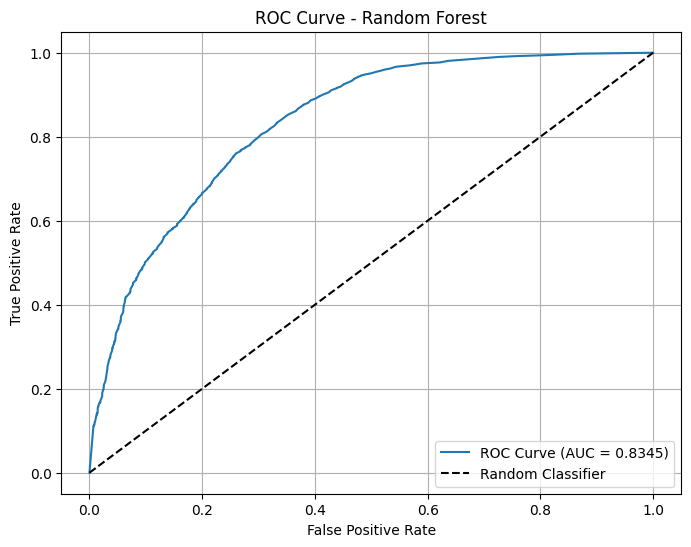

In [128]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Step 1: Get predicted probabilities for the positive class (churn = 1)
y_prob = rf.predict_proba(X_test)[:, 1]

# Step 2: Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Step 3: Plot the ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [129]:
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
import random
from sklearn.metrics import roc_auc_score

# Define the parameter distribution
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(5, 50),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

n_iter = 10  # Number of iterations for random search
random.seed(42)
param_list = []
for _ in range(n_iter):
    params = {
        'n_estimators': param_dist['n_estimators'].rvs(),
        'max_depth': param_dist['max_depth'].rvs(),
        'min_samples_split': param_dist['min_samples_split'].rvs(),
        'min_samples_leaf': param_dist['min_samples_leaf'].rvs(),
        'max_features': random.choice(param_dist['max_features']),
        'bootstrap': random.choice(param_dist['bootstrap']),
    }
    param_list.append(params)

# Track best model and score
best_model = None
best_score = 0
best_params = None

for params in param_list:
    rf = RandomForestClassifier(**params, random_state=42)
    rf.fit(X_train, y_train)
    y_prob = rf.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_prob)

    if auc > best_score:
        best_score = auc
        best_model = rf
        best_params = params

# Print best results
print("Best AUC:", round(best_score, 4))
print("Best Parameters:")
print(best_params)


,n_estimators,908
,criterion,'gini'
,max_depth,17
,min_samples_split,8
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


,n_estimators,610
,criterion,'gini'
,max_depth,6
,min_samples_split,16
,min_samples_leaf,9
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,False
,oob_score,False


,n_estimators,142
,criterion,'gini'
,max_depth,7
,min_samples_split,16
,min_samples_leaf,7
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


,n_estimators,702
,criterion,'gini'
,max_depth,33
,min_samples_split,12
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


,n_estimators,653
,criterion,'gini'
,max_depth,19
,min_samples_split,12
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


,n_estimators,834
,criterion,'gini'
,max_depth,13
,min_samples_split,3
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,False
,oob_score,False


,n_estimators,656
,criterion,'gini'
,max_depth,35
,min_samples_split,6
,min_samples_leaf,4
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


,n_estimators,906
,criterion,'gini'
,max_depth,37
,min_samples_split,6
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


,n_estimators,368
,criterion,'gini'
,max_depth,20
,min_samples_split,11
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


,n_estimators,222
,criterion,'gini'
,max_depth,11
,min_samples_split,17
,min_samples_leaf,4
,min_weight_fraction_leaf,0.0
,max_features,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Best AUC: 0.8595
Best Parameters:
{'n_estimators': 142, 'max_depth': 7, 'min_samples_split': 16, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'bootstrap': True}



Confusion Matrix:
[[1677  756]
 [ 574 3407]]


<Axes: >

Text(0.5, 23.52222222222222, 'Predicted')

Text(50.72222222222221, 0.5, 'Actual')

Text(0.5, 1.0, 'Confusion Matrix')

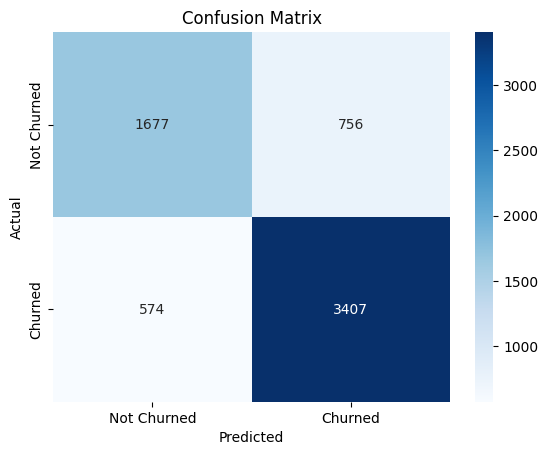


Precision: 0.8184
Recall:    0.8558


In [130]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Predict class labels at default threshold (0.5)
y_pred = best_model.predict(X_test)

# Step 2: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Optional: Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Churned', 'Churned'], yticklabels=['Not Churned', 'Churned'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Step 3: Precision and Recall
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"\nPrecision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")


<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC AUC Curve - Random Forest (Best Model)')

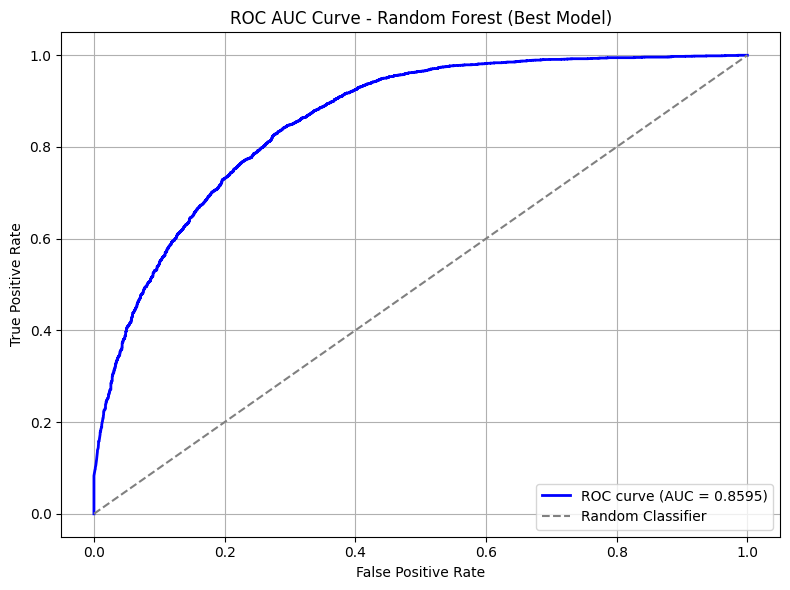

In [131]:
y_prob = best_model.predict_proba(X_test)[:, 1]

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve - Random Forest (Best Model)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [175]:
from sklearn.metrics import precision_score, recall_score

thresholds = np.arange(0.0, 1.01, 0.01)
for thresh in thresholds:
    y_pred = (y_prob >= thresh).astype(int)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    if recall >= 0.90:  # Or your desired threshold
        print(f"Threshold: {thresh:.2f} | Recall: {recall:.2f} | Precision: {precision:.2f}")


Threshold: 0.00 | Recall: 1.00 | Precision: 0.62
Threshold: 0.01 | Recall: 1.00 | Precision: 0.62
Threshold: 0.02 | Recall: 1.00 | Precision: 0.62
Threshold: 0.03 | Recall: 1.00 | Precision: 0.64
Threshold: 0.04 | Recall: 1.00 | Precision: 0.66
Threshold: 0.05 | Recall: 0.99 | Precision: 0.68
Threshold: 0.06 | Recall: 0.99 | Precision: 0.69
Threshold: 0.07 | Recall: 0.99 | Precision: 0.70
Threshold: 0.08 | Recall: 0.99 | Precision: 0.71
Threshold: 0.09 | Recall: 0.99 | Precision: 0.71
Threshold: 0.10 | Recall: 0.98 | Precision: 0.72
Threshold: 0.11 | Recall: 0.98 | Precision: 0.73
Threshold: 0.12 | Recall: 0.98 | Precision: 0.73
Threshold: 0.13 | Recall: 0.98 | Precision: 0.74
Threshold: 0.14 | Recall: 0.98 | Precision: 0.74
Threshold: 0.15 | Recall: 0.98 | Precision: 0.74
Threshold: 0.16 | Recall: 0.98 | Precision: 0.75
Threshold: 0.17 | Recall: 0.97 | Precision: 0.75
Threshold: 0.18 | Recall: 0.97 | Precision: 0.75
Threshold: 0.19 | Recall: 0.97 | Precision: 0.75
Threshold: 0.20 | Re

In [178]:
from sklearn.metrics import fbeta_score

# Example: F2-score gives 2x more weight to recall
thresholds = np.arange(0.0, 1.0, 0.01)
best_thresh, best_f2 = 0, 0

for t in thresholds:
    y_pred = (y_prob >= t).astype(int)
    f2 = fbeta_score(y_test, y_pred, beta=2)
    if f2 > best_f2:
        best_f2 = f2
        best_thresh = t

print(f"Best F2 Score: {best_f2:.4f} at Threshold: {best_thresh:.2f}")


Best F2 Score: 0.9196 at Threshold: 0.15


In [185]:
import numpy as np

j_scores = tpr - fpr
best_idx = np.argmax(j_scores)
best_thresh = thresholds[best_idx]

print(f"Best Threshold (Youden's J): {best_thresh:.3f}")

Best Threshold (Youden's J): 0.517


In [182]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Adjust threshold array to same length as fpr/tpr
thresholds = thresholds[:len(fpr)]

distances = np.sqrt((1 - tpr)**2 + fpr**2)
best_idx = np.argmin(distances)
best_thresh = thresholds[best_idx]

print(f"Best Threshold (min dist to top-left): {best_thresh:.3f}")

Best Threshold (min dist to top-left): 0.575


Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC Curve with Best Threshold')

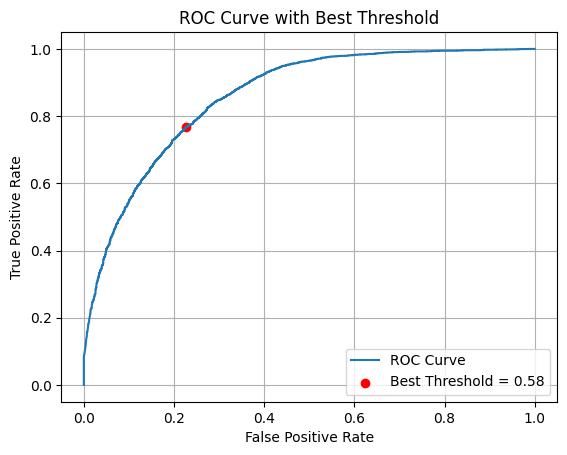

In [183]:
plt.plot(fpr, tpr, label='ROC Curve')
plt.scatter(fpr[best_idx], tpr[best_idx], color='red', label=f'Best Threshold = {best_thresh:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Best Threshold')
plt.legend()
plt.grid(True)
plt.show()


Confusion Matrix (Threshold = 0.517):
[[1727  706]
 [ 631 3350]]


<Axes: >

Text(0.5, 23.52222222222222, 'Predicted')

Text(50.72222222222221, 0.5, 'Actual')

Text(0.5, 1.0, 'Confusion Matrix (Threshold = 0.517)')

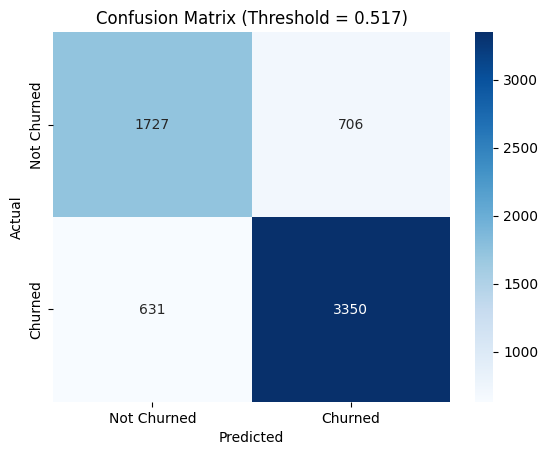


Precision: 0.8259
Recall:    0.8415
Accuracy:  0.7915


In [188]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Predict probabilities for the positive class (churn = 1)
y_prob = best_model.predict_proba(X_test)[:, 1]

# Step 2: Apply custom threshold
custom_threshold = 0.517
y_pred = (y_prob >= custom_threshold).astype(int)

# Step 3: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(f"\nConfusion Matrix (Threshold = {custom_threshold}):")
print(cm)

# Step 4: Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Churned', 'Churned'],
            yticklabels=['Not Churned', 'Churned'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Threshold = {custom_threshold})')
plt.show()

# Step 5: Precision and Recall
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f"\nPrecision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"Accuracy:  {accuracy:.4f}")

* ### Random Forest Classifier with Custom Threshold = 0.3 is giving better results than default threshold = 0.5

<Figure size 1000x600 with 0 Axes>

<BarContainer object of 10 artists>

Text(0.5, 1.0, 'Feature Importances - Random Forest')

Text(0.5, 0, 'Importance Score')

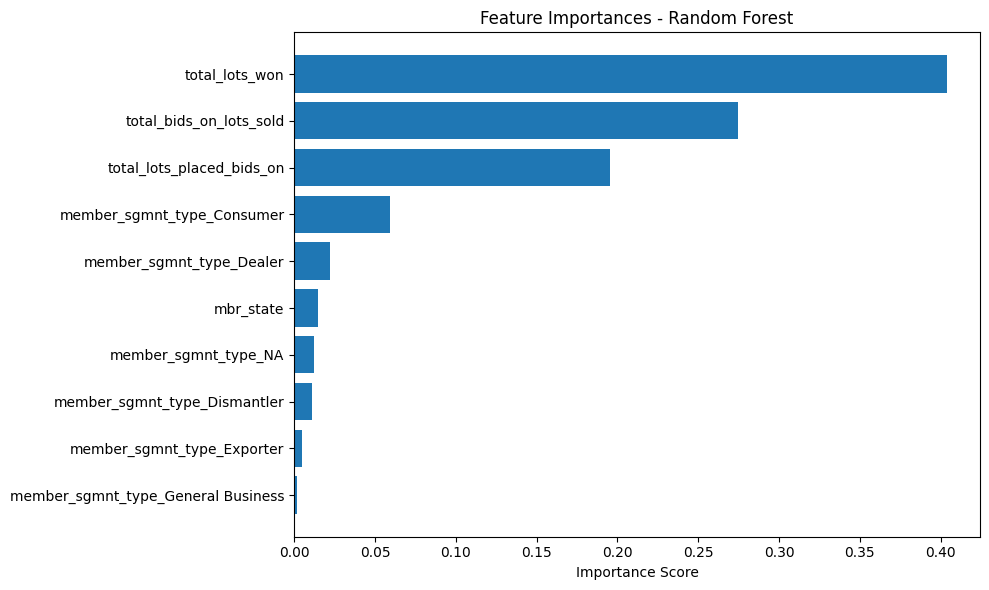

In [138]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Get feature importances and feature names
importances = best_model.feature_importances_
feature_names = X_train.columns

# Step 2: Create DataFrame for easy sorting
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Step 3: Plot
plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'])
plt.gca().invert_yaxis()  # Most important on top
plt.title('Feature Importances - Random Forest')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

In [154]:
import shap

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

In [159]:
print(type(shap_values))
print(np.array(shap_values).shape)

<class 'numpy.ndarray'>
(6414, 10, 2)


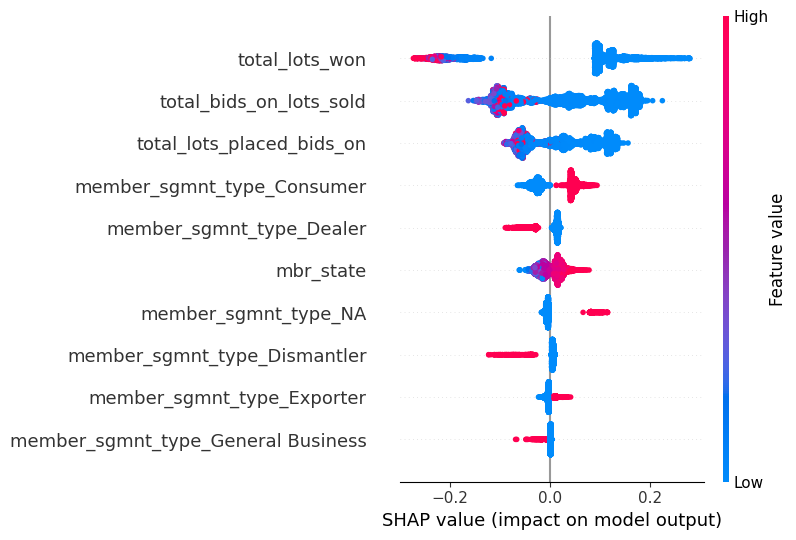

In [160]:
# Extract SHAP values for class 1 (churn)
shap_values_churn = shap_values[:, :, 1]

# Now do the summary plot
shap.summary_plot(shap_values_churn, X_test)

### Findings :-
1. Total lots won, total bids and total lots where bids were placed are the most important features for predicting churn.
2. There are gaps in total_lots_won due to low cardinality of the feature. This is because many members have not won any lots in the last 3 months.
3. There are gaps in other cols due to the features being discrete.